# Naive Bayes spam filter

**Key assumption**

Words occur independently of each other given the label of the document

$$p(w_1,...,w_n|spam) = \prod^{n}_{i=1} p(w_i|spam)$$

Spam classification via Bayes Rule

$$p(spam|w_1,...,w_n) \propto p(spam)\prod^{n}_{i=1}p(w_i|spam)$$

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import torch
import mxnet as mx
from mxnet import nd
import numpy as np
from tqdm import tqdm

In [5]:
def transform(data, label):
    return (nd.floor(data/128)).astype(np.float32), label.astype(np.float32)
mnist_train = mx.gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = mx.gluon.data.vision.MNIST(train=False, transform=transform)

In [6]:
# initialize the counters
xcount = nd.ones((784, 10))
ycount = nd.ones((10))

for data, label in tqdm(mnist_train):
    y = int(label)
    ycount[y] += 1
    xcount[:, y] += data.reshape((784))
    
# using broadcast again for division
py = ycount/ycount.sum()
px = (xcount/ycount.reshape(1,10))

100%|██████████| 60000/60000 [00:48<00:00, 1235.62it/s]


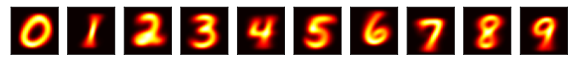

Class probabilities 
[0.09871688 0.11236461 0.09930012 0.10218297 0.09736711 0.09035161
 0.09863356 0.10441593 0.09751708 0.09915014]
<NDArray 10 @cpu(0)>


In [7]:
# Plot xcount mean
fig, figarr = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
    figarr[i].imshow(xcount[:, i].reshape(28,28).asnumpy(), cmap='hot')
    figarr[i].axes.get_xaxis().set_visible(False)
    figarr[i].axes.get_yaxis().set_visible(False)
    
plt.show()
print('Class probabilities', py)

# naive normalization ( without logsum )

In [8]:
data, label = mnist_test[0]
data = data.reshape((784, 1))

# Compute the per pixel conditional probabilities
xprob = (px * data + (1-px) * (1-data))
# take the prdocut
xprob = xprob.prod(0) * py
print("Unnormalized probabilities", xprob)
# and normalix
xprob /= xprob.sum()
print("Normalized probabilities", xprob)

Unnormalized probabilities 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<NDArray 10 @cpu(0)>
Normalized probabilities 
[nan nan nan nan nan nan nan nan nan nan]
<NDArray 10 @cpu(0)>


# Normaliztion (with logsum)

In [9]:
logpx = nd.log(px)
logpxneg = nd.log(1-px)
logpy = nd.log(py)
def bayespost(data):
    logpost = logpy.copy()
    logpost += (logpx*data + logpxneg * (1-data)).sum(0)
    logpost -= nd.max(logpost)
    post = nd.exp(logpost).asnumpy()
    post /= np.sum(post)
    return post

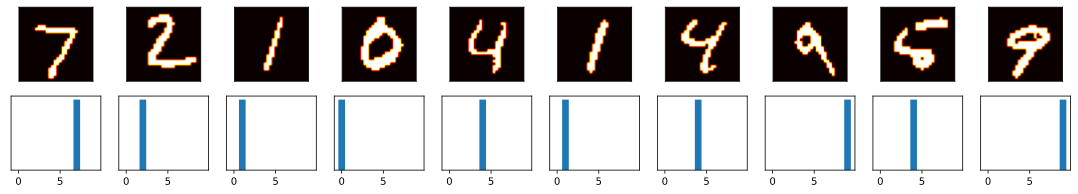

In [13]:
fig, figarr = plt.subplots(2, 10, figsize=(19, 3))
ctr = 0
for data, label in mnist_test:
    x = data.reshape((784,1))
    y = int(label)
    post = bayespost(x)
    figarr[1, ctr].bar(range(10), post)
    figarr[1, ctr].axes.get_xaxis().set_visible(False)
    figarr[1, ctr].axes.get_yaxis().set_visible(False)
    figarr[0, ctr].imshow(x.reshape((28, 28)).asnumpy(), cmap='hot')
    figarr[0, ctr].axes.get_xaxis().set_visible(False)
    figarr[0, ctr].axes.get_yaxis().set_visible(False)
    ctr += 1
    if ctr == 10: break
plt.show()

# Compute accuracy

In [17]:
# initialize counter
ctr = 0
err = 0

for data, label in tqdm(mnist_test):
    ctr += 1
    x = data.reshape((784,1))
    y = int(label)

    post = bayespost(x)
    if (post[y] < post.max()):
        err += 1

print('Naive Bayes has an error rate of', err/ctr)
print('Naive Bayes accuracy rate of', 1 - err/ctr)

100%|██████████| 10000/10000 [00:06<00:00, 1492.19it/s]

Naive Bayes has an error rate of 0.1574
Naive Bayes accuracy rate of 0.8426
